Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [205]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import cProfile


from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [206]:
UNIVERSE_SIZE = 1_000
NUM_SETS = 100
DENSITY = 0.2

max_iter = 1000
if (UNIVERSE_SIZE > 100 & UNIVERSE_SIZE <= 1000):
    num_restarts = 200
else:
    num_restarts = 15

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(UNIVERSE_SIZE * DENSITY)]))

In [207]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [208]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def tweak(solution):
    new_solution = solution.copy()
    # Randomly decide whether to activate or deactivate a set
    activate_set = rng.random() < 0.5
    # If we decide to activate a set, look for an inactive set
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            # Randomly select a set among the inactive ones
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        # Otherwise, randomly deactivate a set among the active ones
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    # Add an additional probability for further tweaks
    while rng.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution


## Have Fun!

In [209]:
def stochastic_hill_climbing(max_iter, restarts, threshold=100):
    best_solution = None
    best_cost = np.inf
    cost_history = []
    no_improvement_counter = 0  # Add counter for early stopping

    for restart in tqdm(range(restarts)):
        solution = np.random.choice([True, False], size=NUM_SETS)

        if not valid(solution):
            solution = np.full(NUM_SETS, True)

        current_cost = cost(solution)

        for iteration in range(max_iter):
            new_solution = tweak(solution)

            if valid(new_solution):
                new_cost = cost(new_solution)

                # Standard hill climbing (accept if better)
                if new_cost < current_cost:
                    solution = new_solution
                    current_cost = new_cost
                    no_improvement_counter = 0  # Reset counter on improvement
                else:
                    # Stochastic acceptance of worse solutions with probability
                    if np.random.rand() < 0.05:
                        solution = new_solution
                        current_cost = new_cost

                    # Increment no improvement counter
                    no_improvement_counter += 1

                # Check for best solution
                if current_cost <= best_cost:
                    best_solution = solution
                    best_cost = current_cost
                    cost_history.append(best_cost)
                    no_improvement_counter = 0  # Reset on finding a new best solution

            # Early stopping based on threshold
            if no_improvement_counter >= threshold:
                break  # Exit early if no improvements for `threshold` iterations


    return best_solution, best_cost, cost_history


### Solution with parallelization, optimal for bigger cases

Running Stochastic Hill Climbing: 100%|██████████| 200/200 [00:00<?, ?it/s]


Final cost: 5894.852203383335


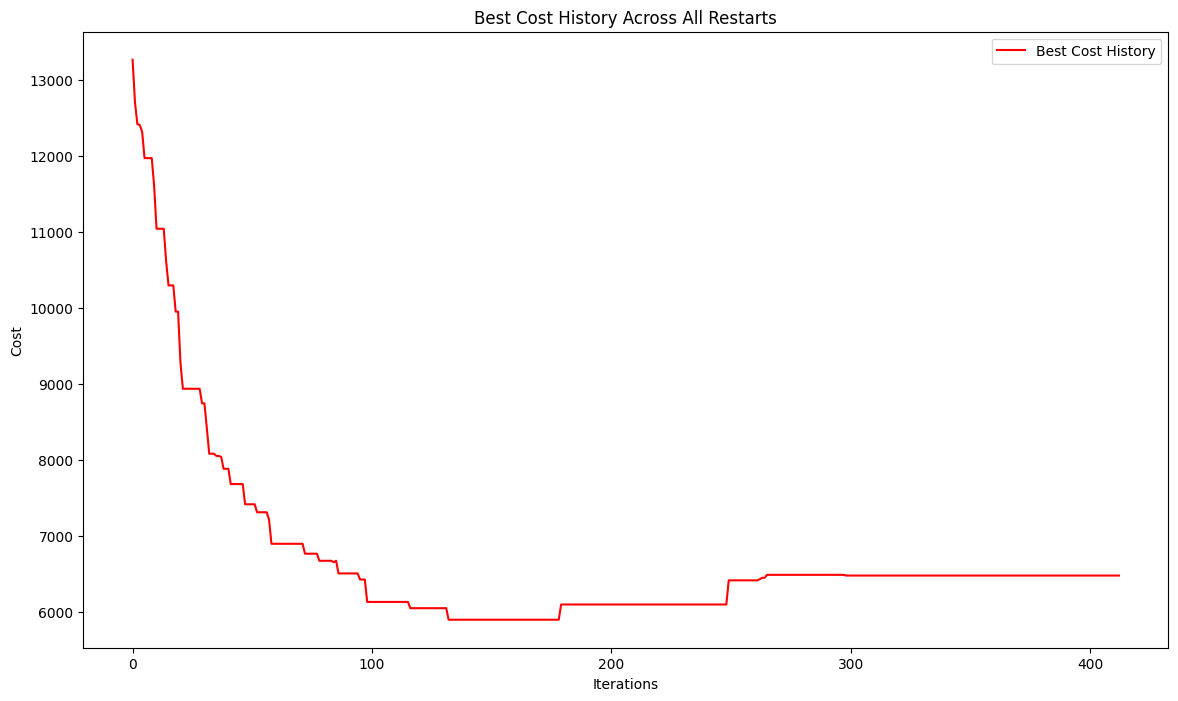

         781021 function calls (772516 primitive calls) in 3.459 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 2077533108.py:2(run_parallel_stochastic_hill_climbing)
      201    0.000    0.000    0.000    0.000 2077533108.py:29(<genexpr>)
      201    0.000    0.000    0.004    0.000 2077533108.py:6(<genexpr>)
       11    0.000    0.000    0.000    0.000 <frozen _collections_abc>:804(get)
       16    0.000    0.000    0.000    0.000 <frozen _collections_abc>:811(__contains__)
      112    0.000    0.000    0.000    0.000 <frozen _collections_abc>:819(keys)
        8    0.000    0.000    0.000    0.000 <frozen _collections_abc>:827(values)
      120    0.000    0.000    0.000    0.000 <frozen _collections_abc>:845(__init__)
        7    0.000    0.000    0.000    0.000 <frozen _collections_abc>:848(__len__)
     3808    0.001    0.000    0.004    0.000 <frozen _collections_a

In [210]:
# Main function to run the algorithm in parallel using joblib
def run_parallel_stochastic_hill_climbing(max_iter, num_restarts):
    results = []
    
    # Use tqdm to show progress
    for result in tqdm(Parallel(n_jobs=-1)(
            delayed(stochastic_hill_climbing)(max_iter, restarts=1) for _ in range(num_restarts)
    ), total=num_restarts, desc="Running Stochastic Hill Climbing"):
        results.append(result)
    
    return results


# Main execution and profiling
def main_multiple():
    

    # Run the parallelized hill climbing algorithm
    results = run_parallel_stochastic_hill_climbing(max_iter, num_restarts)

    # Analyzing results and plotting the cost history
    best_costs = [result[1] for result in results]  # Extracting final costs
    cost_histories = [result[2] for result in results]  # Extracting cost histories

    # Get the best solution from all restarts
    final_cost = min(best_costs)
    print(f"Final cost: {final_cost}")

    max_iterations = max(len(history) for history in cost_histories)  # Find the max length of cost histories
    min_cost_history = np.inf * np.ones(max_iterations)  # Initialize with infinity

    # Iterate through each cost history and update the minimum cost history
    for history in cost_histories:
        for i, cost in enumerate(history):
            if cost < min_cost_history[i]:  # Keep track of the best costs
                min_cost_history[i] = cost

    # Plot the minimum cost history
    plt.figure(figsize=(14, 8))
    plt.plot(range(len(min_cost_history)), min_cost_history, color="red", label="Best Cost History")  # Minimum cost history
    plt.title('Best Cost History Across All Restarts')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.legend()
    plt.show()


# Run with profiling
cProfile.run('main_multiple()')

### Single call solution

100%|██████████| 200/200 [00:13<00:00, 15.36it/s]


Final cost: 6122.0950405820595
         3797744 function calls (3791966 primitive calls) in 13.066 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.159    0.159 3325614196.py:2(main_single)
        1    0.000    0.000    0.000    0.000 3508015894.py:1(stochastic_hill_climbing)
   190955    1.911    0.000    4.416    0.000 3815718814.py:1(valid)
   190755    4.877    0.000    7.143    0.000 3815718814.py:10(tweak)
   104732    0.238    0.000    0.696    0.000 3815718814.py:6(cost)
        1    0.000    0.000    0.000    0.000 <frozen _collections_abc>:811(__contains__)
        3    0.000    0.000    0.000    0.000 <frozen _collections_abc>:827(values)
        3    0.000    0.000    0.000    0.000 <frozen _collections_abc>:845(__init__)
        2    0.000    0.000    0.000    0.000 <frozen _collections_abc>:848(__len__)
       15    0.000    0.000    0.000    0.000 <frozen _collections_abc>:911

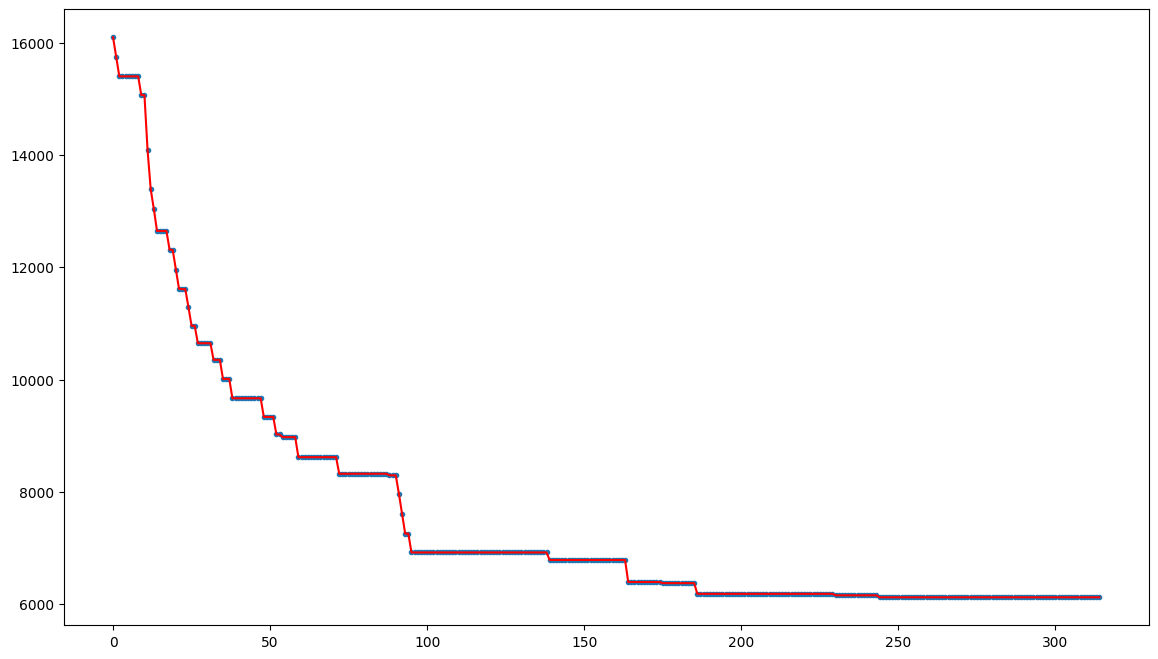

In [211]:
#execute hill climbing
def main_single():
    solution, final_cost, cost_history = stochastic_hill_climbing(max_iter, num_restarts)
    print(f"Final cost: {final_cost}")

    #plot cost history
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(cost_history)),
        list(accumulate(cost_history, min)),
        color="red",
    )
    _ = plt.scatter(range(len(cost_history)), cost_history, marker=".")

cProfile.run('main_single()')